# Extended Four Level System 


"""
-*- coding: utf-8 -*-

Created on Tue Nov  8 15:25:22 2016

@author: marcos

"""


## Modules

In [14]:
import numpy as np
import itertools
import math
from matplotlib import pyplot as plt
from matplotlib import gridspec
import plotly.tools as tls
import plotly
from numpy import linalg as LA
import sys
from ipywidgets import *

%matplotlib inline

## General Functions

In [21]:
def nCr(n,r):
    f = math.factorial
    return f(n) / f(r) / f(n-r)

In [22]:
def dic(x):
    return {
        'A': 10,
        'B': 11,
        'C': 12,
    }.get(x, x)

## Exact Solution Functions

In [19]:
# Generates the allowed configurations of the desidered system
def make_combinations():
    
    combination=[''.join(x) for x in itertools.combinations(states,nume)]

    conf=np.zeros(nume,int)
    config=np.empty((maxocc+1,numtot,nume),int)
    
    for i in range(np.size(combination,0)):
        num_odd=0
        occ=0
        for j in range(nume):
            conf[j]=int(dic(combination[i][j]))
            if conf[j]%2==0:
                num_odd=num_odd+1
            if conf[j]>lastband:
                occ=occ+1

        if num_odd==nume/2 and occ<=maxocc:
            config[occ][dimocc[occ]][:]=conf[:]
            dimocc[occ]=dimocc[occ]+1
        
    k=0    
    for o in range(maxocc+1):
        for p in range(dimocc[o]):
            
            configurations[k+p]=config[o][p][:]
            
        k=k+dimocc[o]   
        

In [2]:
def solver(e1,e2,e3,ea,v1,ua,ja,xa):

    H=compute_H(e1,e2,e3,ea,v1,ua,ja,xa)

    w, v = LA.eig(H)

    mincong=v[:,np.argmin(w)]

    ene=np.min(w)
    n=np.zeros(maxocc+1)
    
    print("Configurations \t Occupation")
    for i in range(numtot):
        if mincong[i]**2>0.01:
            print(configurations[i],"\t",mincong[i]**2)
        occ=0
        for j in range(nume):
            if configurations[i][j]>lastband:
                occ=occ+1
        n[occ]=n[occ]+mincong[i]**2

    #print("n:\n",n)

    print("Energy:\n",ene)

    nn=np.zeros(maxstat)

    for i in range(numtot):
        for j in range(nume):
            for k in range(maxstat):
                if configurations[i][j]==k+1:
                    nn[k]=nn[k]++mincong[i]**2

    #print("nn:\n",nn)

    print("Mean Occupation:\n",np.sum(nn[lastband:]))
    
    show_results(n,nn,w)

In [7]:
def compute_H(e1,e2,e3,ea,v1,ua,ja,xa):
    
    eb=ea
    ec=ea
    
    v2=v1
    v3=v1
    va=0
    vb=0
    vc=0
    
    ub=ua
    uc=ua
    
    ei=np.array([e1,e1,e2,e2,e3,e3,ea,ea,eb,eb,ec,ec])
    vi=np.array([v1,v1,v2,v2,v3,v3,va,va,vb,vb,vc,vc])
    ui=np.array([ua,ub,uc])
    
    energy=np.zeros(numtot)

    for i in range(numtot):
        for j in range(nume):
            energy[i]=energy[i]+ei[configurations[i][j]-1]
            
            
    H=np.zeros((numtot,numtot))
    
    for i in range(numtot):
        H[i][i]=energy[i]
        
        up=0
        doboc=0
        ne=0
        for l in range(nume-1):
            a=configurations[i][l]
            if a>lastband:
                ne=ne+1
                # U            
                if a%2==1 and (a+1)==configurations[i][l+1]:
                    H[i][i]=H[i][i]+ui[int((configurations[i][l]-lastband-1)/2)]
                    doboc=doboc+1
                    
                if a%2==1:
                    up=up+1
        # Falta ver si el ultimo es par
        a=configurations[i][nume-1]
        if a>lastband:
            ne=ne+1
            if a%2==1:
                up=up+1
            
        j=ne-doboc
        
        # Aca tengo j orbitales distintos, up electrones up, doboc doblemente occ
        if j>1:
            ne=j+doboc
            nj=nCr(j,2)
            nx=0
            # J            
            if doboc>0:
                if j==2:
                    nj=nj+doboc*nCr(j,2)
                else:
                    nj=nj+doboc*(nCr(j,2)-nCr(j-1,2))
            # Jx            
            if up>1:
                nx=nx+nCr(up,2)
            if (ne-up)>1:
                nx=nx+nCr((ne-up),2)
            
            H[i][i]=H[i][i]+ja*nj-xa*nx
            
    cont=0
    for o in range(maxocc):
        for i in range(cont+dimocc[o],cont+dimocc[o]+dimocc[o+1]):
            for j in range(cont,cont+dimocc[o]):
                for l in range(nume):
        
                    newconf=np.array(configurations[j])
                    val=newconf[l]
                    newconf=np.delete(newconf,l)
                    newconf=np.append(newconf,val)
                    
                    for ll in range(nume):
                        
                        newconfi=np.array(configurations[i])
                        vali=newconfi[ll]
                        newconfi=np.delete(newconfi,ll)
                        newconfi=np.append(newconfi,vali)
                        
                        aux=np.add(newconfi,-newconf)
                        mult=(-1)**(l+1+ll)
                        
                        allow=1
                        for k in range(nume-1):
                            if aux[k]!=0:
                                allow=0
                        k=nume-1
                        if allow==1 and aux[k]%2==0:
                            H[i][j]=(vi[newconfi[k]-1]-vi[newconf[k]-1])*mult
                        
        cont=cont+dimocc[o]
    
    
    return np.array(H+H.T - np.diag(H.diagonal()))

## HF Solution Functions

In [3]:
def solverHF(e1,e2,e3,ea,v1,ua,ja,xa):

    nHF=np.array([1,0,0,1])
    ite=0
    ene=0
    err=errmax+1

    while(ite<itemax and err>errmax):

        ite=ite+1

        H=compute_HF(e1,e2,e3,ea,v1,ua,ja,xa,nHF)

        w, v = LA.eig(H)

        mincong=np.empty((nume,maxstat))

        waux=np.array(w)

        enev=ene
        ene=0

        for i in range(nume):

            amin=np.argmin(waux)

            ene=ene+np.min(waux)

            mincong[i][:]=v[:,amin]

            waux[amin]=np.max(waux)+1

        nnn=np.zeros((nume,maxstat))
        nn=np.zeros((maxstat))

        #print("Orbitals:")
        for k in range(nume):
            #print("State",k)
            for i in range(maxstat):
                #if mincong[k][i]**2>0.01:
                    #print(i+1,"\t",mincong[k][i]**2)

                nnn[k][i]=nnn[k][i]+mincong[k][i]**2

        #print("n:\n",nn)

        for i in range(nume):
            nn[:]=nn[:]+np.array(nnn[i,:])

        nHF=nHF*0.5+0.5*np.array(nn[lastband:])

        ene=ene+compute_E(e1,e2,e3,ea,v1,ua,ja,xa,nHF)

        err=abs(ene-enev)
        
    n=np.zeros(maxocc+1)
    
    print("Iterations:",ite)
    print("Orbitals:")
    for k in range(nume):
        print("State",k)
        for i in range(maxstat):
            if nnn[k][i]>0.01:
                print(i+1,"\t",nnn[k][i])
    
    k=0
    if(int(np.sum(nn[lastband:])) ==k ):
        n[k]=np.sum(nn[:lastband])
    for k in range(1,maxocc+1):                
        if(int(np.sum(nn[lastband:])) ==k ):
            n[k]=np.sum(nn[lastband:])

    #print("n:\n",nn)

    print("Energy:\n",ene)

    print("Mean Occupation:\n",np.sum(nn[lastband:]))
    
    # n=np.array((np.sum(nn[:lastband]),np.sum(nn[lastband:])))

    show_results(n,nn,w)

In [8]:
def compute_HF(e1,e2,e3,ea,v1,ua,ja,xa,nHF):
                  
    eb=ea
    ec=ea
    
    v2=v1
    v3=v1
    va=0
    vb=0
    vc=0
    
    ub=ua
    uc=ua
    
    ei=np.array([e1,e1,e2,e2,e3,e3,ea,ea,eb,eb,ec,ec])
    vi=np.array([v1,v1,v2,v2,v3,v3,va,va,vb,vb,vc,vc])
    ui=np.array([ua,ub,uc])
            
    H=np.zeros((maxstat,maxstat))
    
    for i in range(maxstat):
        H[i][i]=ei[i]
        
        
    for i in range(lastband,maxstat):

        ii=i+1
        a=i-lastband
       
        # U   
        if ii%2==1:
            H[i][i]=H[i][i]+ui[int(a/2)]*nHF[a+1] 

        else:
            H[i][i]=H[i][i]+ui[int(a/2)]*nHF[a-1]
        
        # J
        for j in range(lastband,maxstat,2):
            b=j-lastband
            if j!=i:
                if ii%2==1 and j!=i+1:
                    H[i][i]=H[i][i]+ja*nHF[b]
                if ii%2==0 and j!=i-1:
                    H[i][i]=H[i][i]+ja*nHF[b]
    
        # Jx   
        if ii%2==1:
            for j in range(lastband,maxstat,2):
                b=j-lastband
                if j!=i:
                    H[i][i]=H[i][i]-xa*nHF[b]
        else:
            for j in range(lastband+1,maxstat,2):
                b=j-lastband
                if j!=i:
                    H[i][i]=H[i][i]-xa*nHF[b]
        
            
        for i in range(lastband,maxstat):
            for j in range(0,i):

                H[i][j]=(vi[i]-vi[j])
                
                        
    return np.array(H+H.T - np.diag(H.diagonal()))

In [9]:
def compute_E(e1,e2,e3,ea,v1,ua,ja,xa,nHF):
    
    eb=ea
    ec=ea
    
    v2=v1
    v3=v1
    va=0
    vb=0
    vc=0
    
    ub=ua
    uc=ua
    
    ei=np.array([e1,e1,e2,e2,e3,e3,ea,ea,eb,eb,ec,ec])
    vi=np.array([v1,v1,v2,v2,v3,v3,va,va,vb,vb,vc,vc])
    ui=np.array([ua,ub,uc])
    
    E=0
    
    for i in range(lastband,maxstat):

        ii=i+1
        a=i-lastband
       
        # U   
        if ii%2==1:
            E=E+ui[int(a/2)]*nHF[a+1]*nHF[a]
        else:
            E=E+ui[int(a/2)]*nHF[a-1]*nHF[a]

        # J
        for j in range(lastband,maxstat,2):
            b=j-lastband
            if j!=i:
                if ii%2==1 and j!=i+1:
                    E=E+ja*nHF[b]*nHF[a]
                if ii%2==0 and j!=i-1:
                    E=E+ja*nHF[b]*nHF[a]
    
        # Jx   
        if ii%2==1:
            for j in range(lastband,maxstat,2):
                b=j-lastband
                if j!=i:
                    E=E-xa*nHF[b]*nHF[a]
        else:
            for j in range(lastband+1,maxstat,2):
                b=j-lastband
                if j!=i:
                    E=E-xa*nHF[b]*nHF[a]
         
    return 0.5*E

## Results Functions

In [1]:
def solvers(e1,e2,e3,ea,v1,ua,ja,xa):
    solverHF(e1,e2,e3,ea,v1,ua,ja,xa)
    solver(e1,e2,e3,ea,v1,ua,ja,xa)


In [10]:
def show_results(n,nn,w):
    
    fig = plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(1, 10)
    ax1 = fig.add_subplot(gs[0,:2])
    ax1.plot(np.sort(w),'o')
    ax1.set_title("E Levels")

    ax2 = fig.add_subplot(gs[0,2:6])
    ax2.bar(np.arange(np.size(n)),n)
    ax2.set_title("Atom Occupation")

    ax3 = fig.add_subplot(gs[0,6:10])
    ax3.bar(np.arange(maxstat),nn)
    ax3.set_title("Orbital Occupation")

    gs.update(wspace=1, hspace=0.5)

    plt.show()
    


## Initialization

In [17]:
nume=4
numn=5
lastband=6
states='123456789A'
maxocc=4
maxstat=10

itemax=100
errmax=0.0000000001

# maxocc 0  1  2  3   4
# numtot 9 45 87 99 100
numtot=100 #int(nCr(numn,int(nume/2))**2)

configurations=np.zeros((numtot,nume),int)
dimocc=np.zeros(maxocc+1,int)

mincong=np.zeros(numtot)
ene=0
n=np.zeros(maxocc+1)

    
make_combinations()

e1=-5
e2=0
e3=5

v1=0
ea=-2

ua=1

ja=0
xa=0

#solver(e1,e2,e3,ea,v1) 

## Interactive Solution

Iterations: 1
Orbitals:
State 0
1 	 1.0
State 1
2 	 1.0
State 2
3 	 1.0
State 3
4 	 1.0
Energy:
 0.0
Mean Occupation:
 0.0


Configurations 	 Occupation
[1 2 3 4] 	 1.0
Energy:
 0.0
Mean Occupation:
 0.0


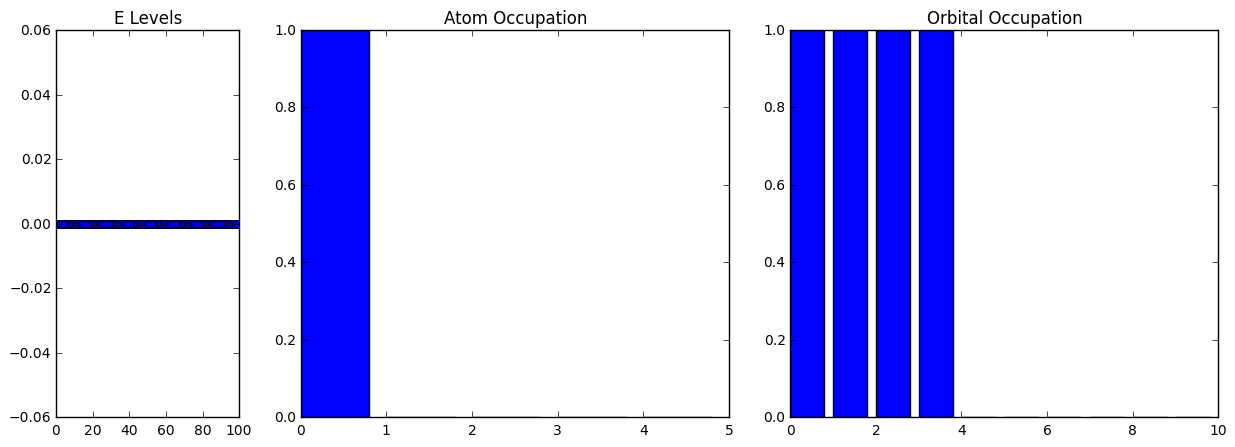

<function __main__.solvers>

In [18]:
interact(solvers,e1=(-5,5,1),e2=(-5,5,1),e3=(-5,5,1),ea=(-5,5,1),v1=(-5,5,1),ua=(-5,5,1),ja=(-5,5,1),xa=(-5,5,1),__manual=False)